In [11]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

In [2]:
def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

In [3]:
model_metadata = pd.read_csv("../../config/models.csv")
palette = model_metadata.set_index("description")["color"].to_dict()
model_renaming = model_metadata.set_index("name")["description"].to_dict()
model_metadata

,name,description,color
0,CADD,CADD,C0
1,GPN-MSA,GPN-MSA,C1
2,Borzoi,Borzoi,C2
3,Enformer,Enformer,C3
4,GPN,gLM-Promoter,C4
5,NucleotideTransformer,NT,C5
6,HyenaDNA,HyenaDNA,C6
7,Caduceus,Caduceus,C7
8,CADD+GPN-MSA+Borzoi,Ensemble,C8


In [38]:
dataset_renaming = {
    "mendelian_traits_all": "Mendelian traits",
    "complex_traits_all": "Complex traits",
    "old/complex_traits_all": "Complex traits",
}

subset_renaming = {
    "all": "All",
    "maf_0.00_0.05": "MAF < 5%",
    "maf_0.05_0.50": r"MAF $\geq$ 5%",

    "maf_0.0_0.1": "MAF 0-10%",
    "maf_0.1_0.2": "MAF 10-20%",
    "maf_0.2_0.3": "MAF 20-30%",
    "maf_0.3_0.4": "MAF 30-40%",
    "maf_0.4_0.5": "MAF 40-50%",
}

In [39]:
datasets = [
    #"mendelian_traits_all",
    "complex_traits_all",
    #"old/complex_traits_all",
]

subsets = [
    #"all",

    #"maf_0.00_0.05",
    #"maf_0.05_0.50",

    "maf_0.0_0.1",
    "maf_0.1_0.2",
    "maf_0.2_0.3",
    "maf_0.3_0.4",
    "maf_0.4_0.5",
]

models = [
    "GPN-MSA",
    "GPN",
    "CADD",
]

def load_score(model, dataset, subset):
    base_dir = f"../../results/dataset/{dataset}/unsupervised_metrics/{subset}"
    if model != "CADD":
        if "mendelian" in dataset:
            llr_version = "LLR"
        elif "complex" in dataset:
            llr_version = "absLLR"
        path = f"{base_dir}/{model}_{llr_version}.csv"
    else:
        path = f"{base_dir}/{model}.csv"
    df = pd.read_csv(path)
    if model == "CADD":
        return df[df.feature=="RawScore"].AUPRC.values[0]
    else:
        return df.AUPRC.values[0]

In [40]:
sample_size = defaultdict(dict)
rows = []
for dataset in datasets:
    base_dir = f"../../results/dataset/{dataset}"
    V = pl.read_parquet(f"{base_dir}/test.parquet")
    for subset in subsets:
        subset_df = pl.read_parquet(f"{base_dir}/subset/{subset}.parquet")
        V_s = subset_df.join(V, on=["chrom", "pos", "ref", "alt"], how="left")
        n = len(V_s)
        n_pos = V_s["label"].sum()
        n_neg = n - n_pos
        pos_prop = n_pos / n
        sample_size[dataset_renaming.get(dataset, dataset)][subset_renaming.get(subset, subset)] = (n_pos, n_neg)
        for model in models:
            score = load_score(model, dataset, subset)
            rows.append([
                dataset_renaming.get(dataset, dataset),
                subset_renaming.get(subset, subset),
                model_renaming.get(model, model),
                score,
                score / pos_prop,
            ])
df = pd.DataFrame(rows, columns=["dataset", "subset", "model", "AUPRC", "AUPRC/baseline"])
df

,dataset,subset,model,AUPRC,AUPRC/baseline
0,Complex traits,MAF 0-10%,GPN-MSA,0.000442,7.866165
1,Complex traits,MAF 0-10%,gLM-Promoter,0.000055,0.986930
2,Complex traits,MAF 0-10%,CADD,0.002042,36.326384
3,Complex traits,MAF 10-20%,GPN-MSA,0.001917,16.614715
4,Complex traits,MAF 10-20%,gLM-Promoter,0.000111,0.965902
5,Complex traits,MAF 10-20%,CADD,0.000906,7.853496
6,Complex traits,MAF 20-30%,GPN-MSA,0.000831,4.395307
7,Complex traits,MAF 20-30%,gLM-Promoter,0.000190,1.007347
8,Complex traits,MAF 20-30%,CADD,0.000914,4.834953
9,Complex traits,MAF 30-40%,GPN-MSA,0.001018,5.374156


In [41]:
sample_size

defaultdict(dict,
            {'Complex traits': {'MAF 0-10%': (420, 7469575),
              'MAF 10-20%': (165, 1430268),
              'MAF 20-30%': (202, 1068224),
              'MAF 30-40%': (177, 934670),
              'MAF 40-50%': (176, 871338)}})

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

Complex traits 1.00E+00
Complex traits 1.00E+00
Complex traits 1.00E+00
Complex traits 1.00E+00
Complex traits 1.00E+00


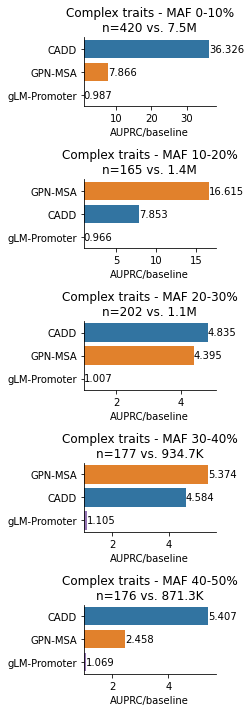

In [42]:
g = sns.FacetGrid(
    data=df,
    col="dataset",
    row="subset",
    #margin_titles=True,
    sharex=False,
    sharey=False,
    height=2,
    aspect=1.8,
)

def my_boxplot(data, **kwargs):
    dataset = data.dataset.iloc[0]
    subset = data.subset.iloc[0]
    n_pos, n_neg = sample_size[dataset][subset]
    data = data.sort_values("AUPRC/baseline", ascending=False)
    ax = plt.gca()
    g = sns.barplot(
        data=data,
        y="model",
        x="AUPRC/baseline",
        ax=ax,
        palette=palette,
    )
    baseline = 1
    ss = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
    print(dataset, f"{baseline:.2E}")
    g.set(
        xlim=baseline,
        title=f"{dataset} - {subset}\n{ss}"
    )
    for bar, model in zip(g.patches, data.model):
        text = f'{bar.get_width():.3f}'
        g.text(
            max(bar.get_width(), baseline),  # X position, here at the end of the bar
            bar.get_y() + bar.get_height()/2,  # Y position, in the middle of the bar
            text,  # Text to be displayed, formatted to 3 decimal places
            va='center'  # Vertical alignment
        )

g.map_dataframe(my_boxplot)
#g.figure.subplots_adjust(hspace=0)

g.set(
    ylabel="",
)
#g.set_titles(
#    col_template="{col_name}", row_template="{row_name}",
#    fontweight="bold",
#    #size=12,
#)
g.tight_layout()
#plt.savefig("../../results/plots/performance_all.pdf", bbox_inches="tight")

In [ ]:
g = sns.FacetGrid(
    data=df,
    col="dataset",
    sharex=False,
    sharey=False,
    height=2,
    aspect=1.8,
)

def my_boxplot(data, **kwargs):
    dataset = data.dataset.iloc[0]
    subset = data.subset.iloc[0]
    n_pos, n_neg = sample_size[dataset][subset]
    data = data.sort_values("AUPRC", ascending=False)
    ax = plt.gca()
    g = sns.barplot(
        data=data,
        y="model",
        x="AUPRC",
        ax=ax,
        palette=palette,
    )
    baseline = n_pos / (n_pos + n_neg)
    ss = f"n={format_number(n_pos)} vs. {format_number(n_neg)}"
    g.set(
        xlim=baseline,
        title=f"{dataset} - {subset}\n{ss}"
    )

g.map_dataframe(my_boxplot)
#g.figure.subplots_adjust(hspace=0)

g.set(
    ylabel="",
)
#g.set_titles(
#    col_template="{col_name}", row_template="{row_name}",
#    fontweight="bold",
#    #size=12,
#)
g.tight_layout()
#plt.savefig("../../results/plots/performance_all.pdf", bbox_inches="tight")